In [1]:
!pip install -q earthengine-api geemap

import ee
import geemap
import pandas as pd
import numpy as np
import os
from datetime import datetime
from google.colab import files

# Authenticate and Initialize Earth Engine
try:
    ee.Initialize(project='dojo-485716')
except:
    ee.Authenticate()
    ee.Initialize(project='dojo-485716')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00


In [2]:
farmer_portfolio = {
    "George Mukama": [
        {"crop": "Maize", "size": 10, "coords": [[1.11739,33.90203], [1.11665,33.90119], [1.11615,33.90157], [1.11662,33.90255]]},
        {"crop": "Avocado", "size": 5, "coords": [[1.11726,33.9014], [1.11713,33.90152], [1.11688,33.90118], [1.11699,33.90109]]},
        {"crop": "Eucalyptus", "size": 15, "coords": [[1.117927,33.901234], [1.117563, 33.901470], [1.11716,33.90089], [1.11742,33.90071]]}
    ],
    "Tukule Samuel": [
        {"crop": "Coffee", "size": 4, "coords": [[1.078478, 33.884497], [1.079439, 33.884931], [1.080126, 33.884920], [1.079413, 33.885747]]},
        {"crop": "Cassava", "size": 1, "coords": [[1.08106,33.88796], [1.08084,33.88807], [1.08071,33.8878], [1.08095,33.88773]]},
        {"crop": "Maize", "size": 0.5, "coords": [[1.079965, 33.886170], [1.08003, 33.886905], [1.079590, 33.886916], [1.079568, 33.88615]]}
    ],
    "Emmanuel Gonahasa": [
        {"crop": "Avocado", "size": 5, "coords": [[1.05659,33.87743], [1.05638,33.87717], [1.05607,33.87747], [1.05619,33.8776]]},
        {"crop": "Eucalyptus", "size": 12, "coords": [[1.057428, 33.879250], [1.057396, 33.880495], [1.056655, 33.880527], [1.056022, 33.879218]]},
        {"crop": "Maize", "size": 5, "coords": [[1.054167, 33.880752], [1.052815, 33.880817], [1.052601, 33.882553], [1.053995, 33.882769]]}
    ],
    "Noah Natude": [
        {"crop": "Tomatoes", "size": 8, "coords": [[1.070147, 33.885127], [1.069056, 33.885576], [1.068861, 33.886234], [1.069517, 33.886981], [1.070826, 33.886032]]},
        {"crop": "Rice", "size": 30, "coords": [[1.066624, 33.886600], [1.066857, 33.885685], [1.067888, 33.885577], [1.067928, 33.885910], [1.067411, 33.886023], [1.067481, 33.886364], [1.068000, 33.886237], [1.068149, 33.886648], [1.067708, 33.886846]]},
        {"crop": "Groundnuts", "size": 8, "coords": [[1.070147, 33.885127], [1.069056, 33.885576], [1.068861, 33.886234], [1.069517, 33.886981], [1.070826, 33.886032]]}
    ],
    "James Balya": [
        {"crop": "Oranges", "size": 2.5, "coords": [[0.982982, 33.857992], [0.982250, 33.858040],[0.982145, 33.858709], [0.983219, 33.858857], [0.983246, 33.858403], [0.982827, 33.858311]]}
    ],
    "Cornelius Kaberwa": [
        {"crop": "Rice", "size": 3, "coords": [[1.117927, 33.901234], [1.117563, 33.901470], [1.117638, 33.900633], [1.117906, 33.901244]]}
    ]
}

def get_farm_geometry(coords):
    return ee.Geometry.Polygon([[p[1], p[0]] for p in coords])

In [32]:
def get_comprehensive_farm_analysis(farmer_name, start_date, end_date, existing_records=set()):
    if farmer_name not in farmer_portfolio:
        print(f"Error: Farmer {farmer_name} not found.")
        return pd.DataFrame()

    print(f"Analyzing {farmer_name} (5-day steps)")

    date_range = pd.date_range(start=start_date, end=end_date, freq='5D')
    all_records = []

    unique_parcels = {}
    for farm in farmer_portfolio[farmer_name]:
        coord_tuple = tuple(tuple(c) for c in farm['coords'])
        if coord_tuple not in unique_parcels:
            unique_parcels[coord_tuple] = {'crops': [farm['crop']], 'coords': farm['coords'], 'size': farm['size']}
        else:
            if farm['crop'] not in unique_parcels[coord_tuple]['crops']:
                unique_parcels[coord_tuple]['crops'].append(farm['crop'])

    for parcel_id, info in enumerate(unique_parcels.values(), 1):
        poly = get_farm_geometry(info['coords'])
        crops_str = " & ".join(info['crops'])
        calc_area = poly.area().divide(4046.86).getInfo()
        parcel_key = f"Parcel_{parcel_id}"

        for i in range(len(date_range) - 1):
            p_start = date_range[i]
            p_end = date_range[i+1]
            date_str = p_start.strftime('%Y-%m-%d')

            # --- SMART SKIP LOGIC ---
            # If this specific farmer/parcel/date exists in our Excel, skip the API calls
            if (farmer_name, parcel_key, date_str) in existing_records:
                continue

            p_start_ee, p_end_ee = ee.Date(date_str), ee.Date(p_end.strftime('%Y-%m-%d'))

            # 1. Vegetation Health (Sentinel-2)
            s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterBounds(poly).filterDate(p_start_ee, p_end_ee)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50)))

            health = {'NDVI': None, 'EVI': None, 'NDRE': None, 'NDMI': None}
            if s2.size().getInfo() > 0:
                img = s2.median()
                indices = ee.Image.cat([
                    img.normalizedDifference(['B8', 'B4']).rename('NDVI'),
                    img.expression('2.5 * ((B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1))',
                                    {'B8': img.select('B8'), 'B4': img.select('B4'), 'B2': img.select('B2')}).rename('EVI'),
                    img.normalizedDifference(['B8', 'B5']).rename('NDRE'),
                    img.normalizedDifference(['B8', 'B11']).rename('NDMI')
                ])
                h_stats = indices.reduceRegion(ee.Reducer.mean(), poly, 10).getInfo()
                health = {k: round(v, 3) if v else None for k, v in h_stats.items()}

            # 2. Weather, Rainfall & Soil (ERA5-Land)
            era5_coll = (ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
                        .filterBounds(poly).filterDate(p_start_ee, p_end_ee))

            weather = {'Rain_mm': 0, 'Temp_C': None, 'Hum_Pct': None, 'Wind_ms': None, 'Solar_MJ': None, 'Soil_Moist': None}

            if era5_coll.size().getInfo() > 0:
                rain_total = era5_coll.select('total_precipitation_sum').sum().multiply(1000)
                solar_total = era5_coll.select('surface_solar_radiation_downwards_sum').sum()
                met_mean = era5_coll.select(['temperature_2m', 'dewpoint_temperature_2m', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'volumetric_soil_water_layer_1']).mean()

                combined_met = met_mean.addBands(rain_total).addBands(solar_total)
                met_stats = combined_met.reduceRegion(ee.Reducer.mean(), poly, 1000).getInfo()

                weather['Rain_mm'] = round(met_stats.get('total_precipitation_sum') or 0, 1)
                t2m, d2m = met_stats.get('temperature_2m'), met_stats.get('dewpoint_temperature_2m')
                if t2m and d2m:
                    tc, dc = t2m - 273.15, d2m - 273.15
                    weather['Temp_C'], weather['Hum_Pct'] = round(tc, 1), round(100 * (np.exp((17.625 * dc)/(243.04 + dc)) / np.exp((17.625 * tc)/(243.04 + tc))), 1)
                u, v = met_stats.get('u_component_of_wind_10m'), met_stats.get('v_component_of_wind_10m')
                if u and v: weather['Wind_ms'] = round(np.sqrt(u**2 + v**2), 2)
                sol = met_stats.get('surface_solar_radiation_downwards_sum')
                if sol: weather['Solar_MJ'] = round(sol / 1_000_000, 2)
                sm = met_stats.get('volumetric_soil_water_layer_1')
                if sm: weather['Soil_Moist'] = round(sm, 3)

            # 3. Flood & Deforestation Status (Sentinel-1 Radar)
            flood_status = "No Flood"
            deforest_status = "Stable"

            s1_coll = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(poly).filterDate(p_start_ee, p_end_ee)

            if s1_coll.size().getInfo() > 0:
                s1_img = s1_coll.median()

                # Flood (VV band)
                f_ratio = s1_img.select('VV').lt(-16).reduceRegion(ee.Reducer.mean(), poly, 10).getInfo().get('VV') or 0
                if f_ratio > 0.1: flood_status = f"Flood Detected ({f_ratio*100:.1f}%)"

                # Deforestation (VH band vs 1-year baseline)
                try:
                    baseline_start = p_start_ee.advance(-1, 'year')
                    baseline_end = baseline_start.advance(5, 'day')
                    s1_hist = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(poly).filterDate(baseline_start, baseline_end).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).median().select('VH')

                    if s1_hist.bandNames().size().getInfo() > 0:
                        # Drop > 3dB in VH backscatter indicates loss of woody structure
                        loss_mask = s1_hist.subtract(s1_img.select('VH')).gt(3)
                        loss_ratio = loss_mask.reduceRegion(ee.Reducer.mean(), poly, 10).getInfo().get('VH') or 0
                        if loss_ratio > 0.15: # 15% threshold for alert
                            deforest_status = f"Alert: Biomass Loss ({loss_ratio*100:.1f}%)"
                except: pass

            all_records.append({
                'Farmer_Name': farmer_name, 'Parcel_ID': parcel_key, 'Crops': crops_str, 'Calculated_Acres': round(calc_area, 2),
                'Step_Start': date_str, 'Month_Group': p_start.strftime('%Y-%m'),
                'NDVI': health['NDVI'], 'EVI': health['EVI'], 'NDRE': health['NDRE'], 'NDMI': health['NDMI'],
                'Rainfall_mm': weather['Rain_mm'], 'Temperature_C': weather['Temp_C'], 'Humidity_Pct': weather['Hum_Pct'],
                'Wind_Speed_ms': weather['Wind_ms'], 'Solar_Rad_MJ_m2': weather['Solar_MJ'], 'Soil_Moisture_0_7cm': weather['Soil_Moist'],
                'Flood_Status': flood_status, 'Deforestation_Status': deforest_status
            })

    return pd.DataFrame(all_records)

In [35]:
import os
from google.colab import drive
from datetime import datetime, timedelta

# 1. MOUNT GOOGLE DRIVE
# This will trigger a pop-up asking for permission to access your Drive
drive.mount('/content/drive')

# 2. SETUP PATHS
folder_path = '/content/drive/MyDrive/Dojohub_Analysis'
file_path = os.path.join(folder_path, 'Master_Farmer_Database.xlsx')

# CREATE DIRECTORY IF IT DOES NOT EXIST
# This prevents the OSError you encountered
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Created new directory: {folder_path}")

# 3. CONFIGURATION
analysis_end = datetime.now().strftime('%Y-%m-%d')
# Calculate start date as 5 years ago
analysis_start = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')

# 4. LOAD EXISTING DATA
existing_df = pd.DataFrame()
processed_keys = set()

if os.path.exists(file_path):
    print("Loading existing database...")
    existing_df = pd.read_excel(file_path)
    # Convert dates to strings to ensure matching works correctly
    existing_df['Step_Start'] = existing_df['Step_Start'].astype(str)
    processed_keys = set(zip(existing_df['Farmer_Name'], existing_df['Parcel_ID'], existing_df['Step_Start']))
    print(f"Found {len(processed_keys)} existing records. Processing only new dates.")
else:
    print("No existing database found. A fresh five-year analysis will begin.")

# 5. RUN BATCH ANALYSIS
new_records = []
for farmer in farmer_portfolio.keys():
    # Calling the function with processed_keys to skip existing data
    df = get_comprehensive_farm_analysis(farmer, analysis_start, analysis_end, existing_records=processed_keys)
    if not df.empty:
        new_records.append(df)

# 6. MERGE AND SAVE
if new_records:
    new_df = pd.concat(new_records, ignore_index=True)
    final_df = pd.concat([existing_df, new_df], ignore_index=True)

    # Sort data chronologically
    final_df['Step_Start'] = pd.to_datetime(final_df['Step_Start'])
    final_df = final_df.sort_values(['Farmer_Name', 'Parcel_ID', 'Step_Start'])

    # Recalculate monthly aggregates for consistency
    print("Recalculating monthly averages...")
    avg_cols = ['NDVI', 'EVI', 'NDRE', 'NDMI', 'Temperature_C', 'Humidity_Pct', 'Wind_Speed_ms', 'Solar_Rad_MJ_m2', 'Soil_Moisture_0_7cm']
    monthly_avg = final_df.groupby(['Farmer_Name', 'Parcel_ID', 'Month_Group'])[avg_cols].transform('mean')
    for col in avg_cols:
        final_df[f'Monthly_Avg_{col}'] = monthly_avg[col].round(3)
    final_df['Monthly_Total_Rain_mm'] = final_df.groupby(['Farmer_Name', 'Parcel_ID', 'Month_Group'])['Rainfall_mm'].transform('sum').round(1)

    # Save to Google Drive
    final_df.to_excel(file_path, index=False)
    master_df = final_df # Global variable for plotting
    print("-" * 60)
    print(f"SUCCESS: Database updated at {file_path}")
    print(f"Total records in file: {len(final_df)}")
else:
    master_df = existing_df
    print("-" * 60)
    print("No new data to add. Database is already up to date.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading existing database...
Found 4745 existing records. Processing only new dates.
Analyzing George Mukama (5-day steps)
Analyzing Tukule Samuel (5-day steps)
Analyzing Emmanuel Gonahasa (5-day steps)
Analyzing Noah Natude (5-day steps)
Analyzing James Balya (5-day steps)
Analyzing Cornelius Kaberwa (5-day steps)
------------------------------------------------------------
No new data to add. Database is already up to date.


----------------------------------------------------------------------------------------------------
REPORT FOR: GEORGE MUKAMA
CROPS: Maize
----------------------------------------------------------------------------------------------------


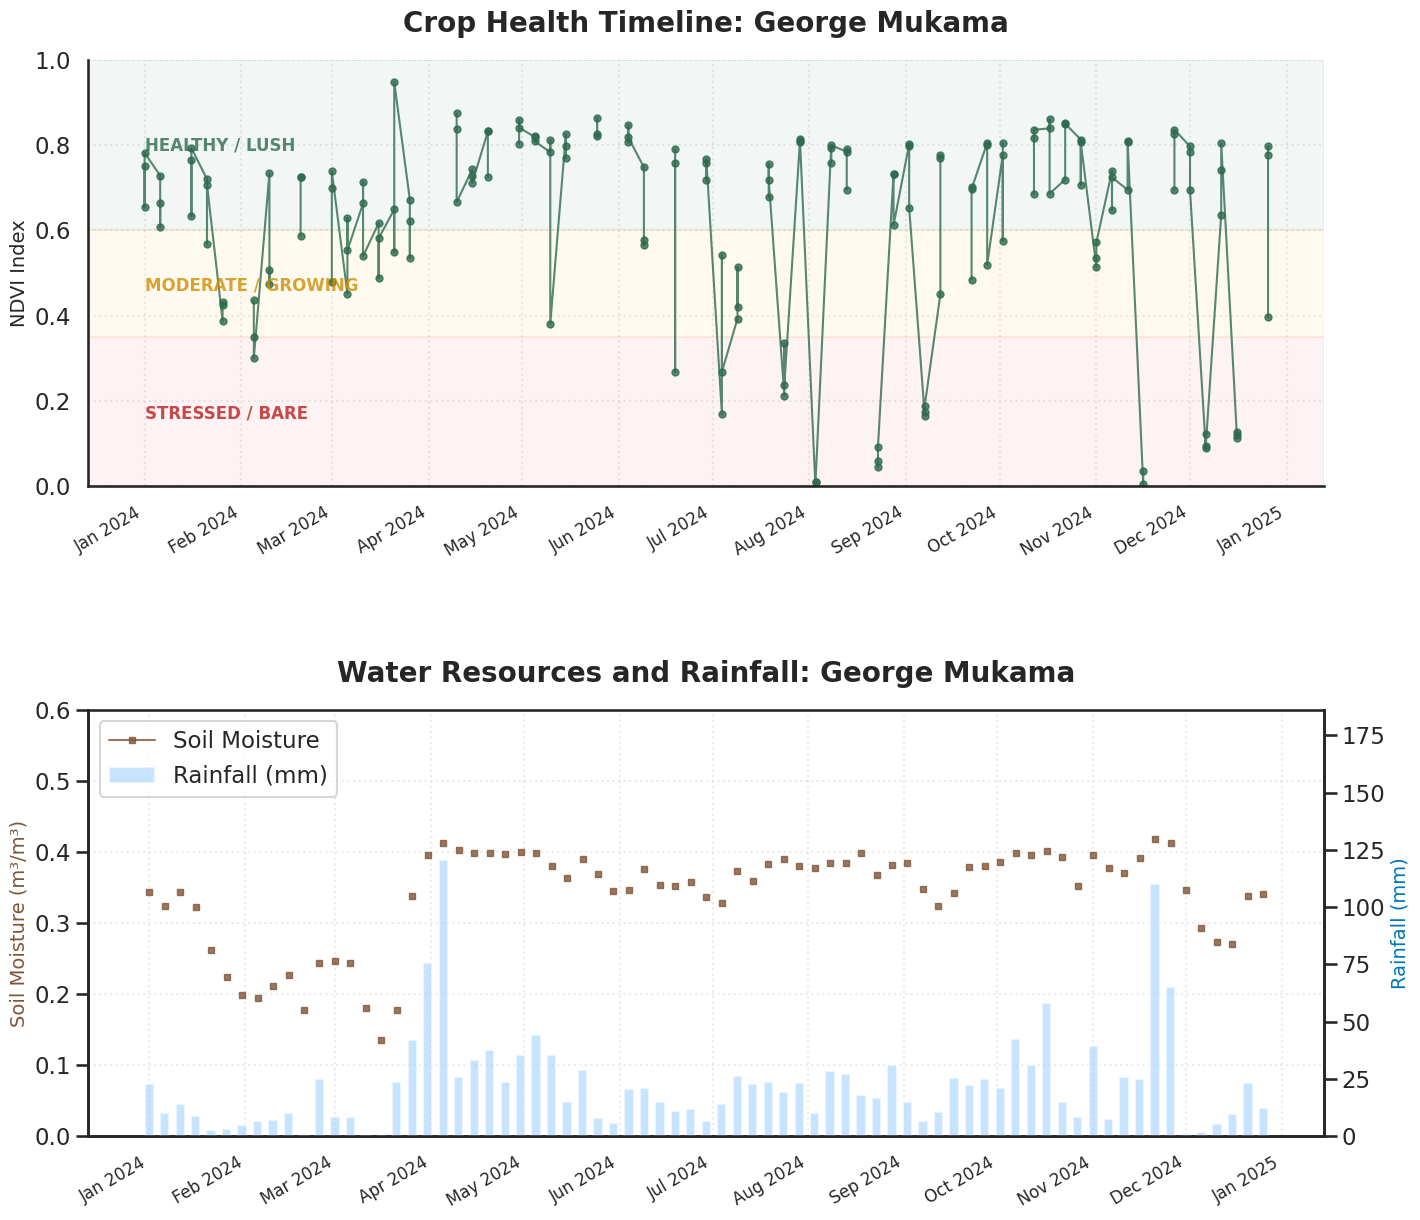



----------------------------------------------------------------------------------------------------
REPORT FOR: TUKULE SAMUEL
CROPS: Coffee
----------------------------------------------------------------------------------------------------


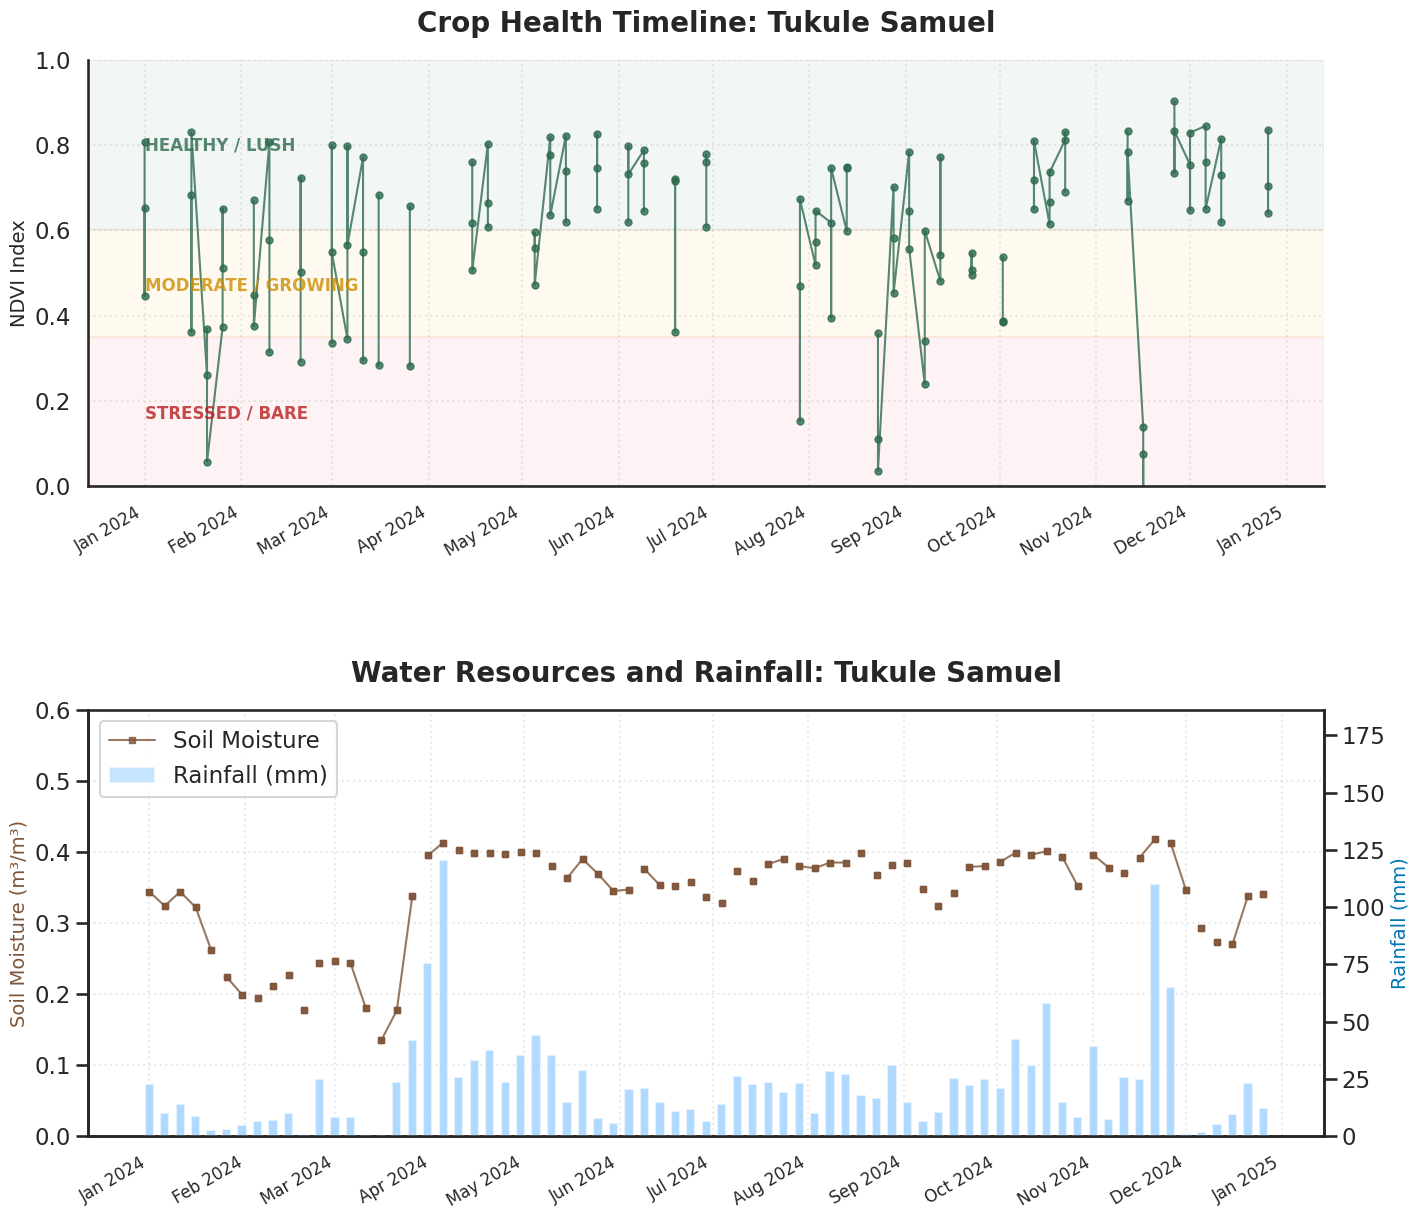



----------------------------------------------------------------------------------------------------
REPORT FOR: EMMANUEL GONAHASA
CROPS: Avocado
----------------------------------------------------------------------------------------------------


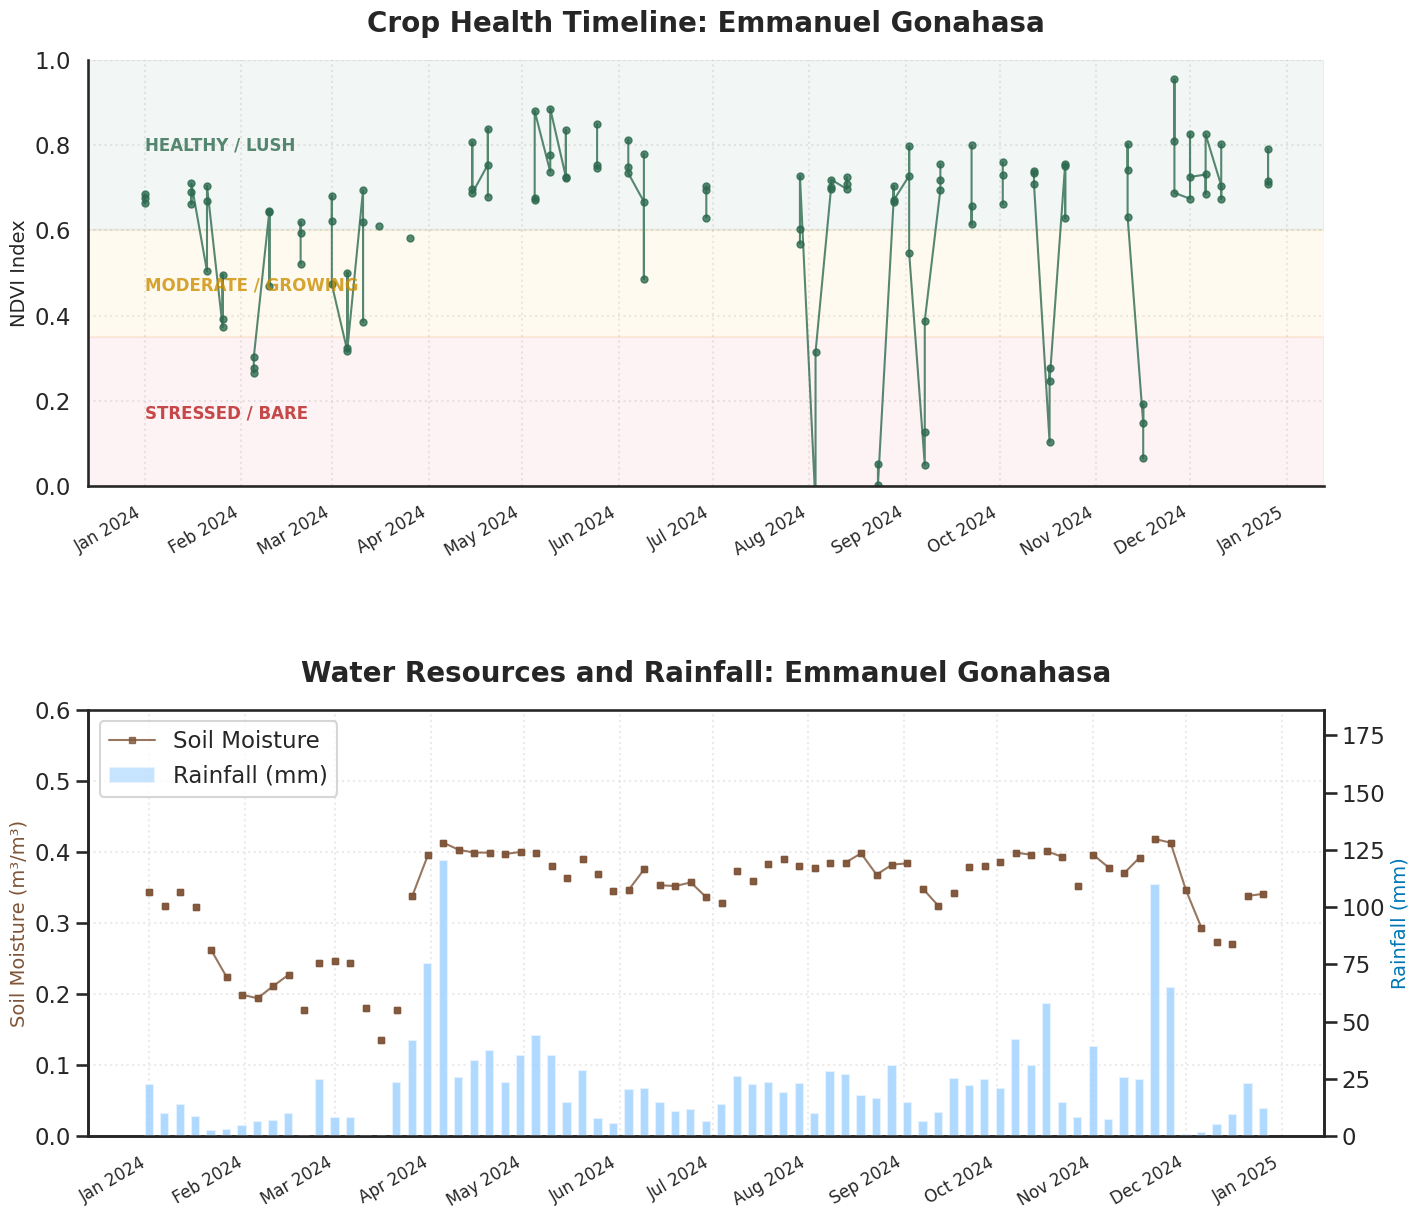



----------------------------------------------------------------------------------------------------
REPORT FOR: NOAH NATUDE
CROPS: Tomatoes & Groundnuts
----------------------------------------------------------------------------------------------------


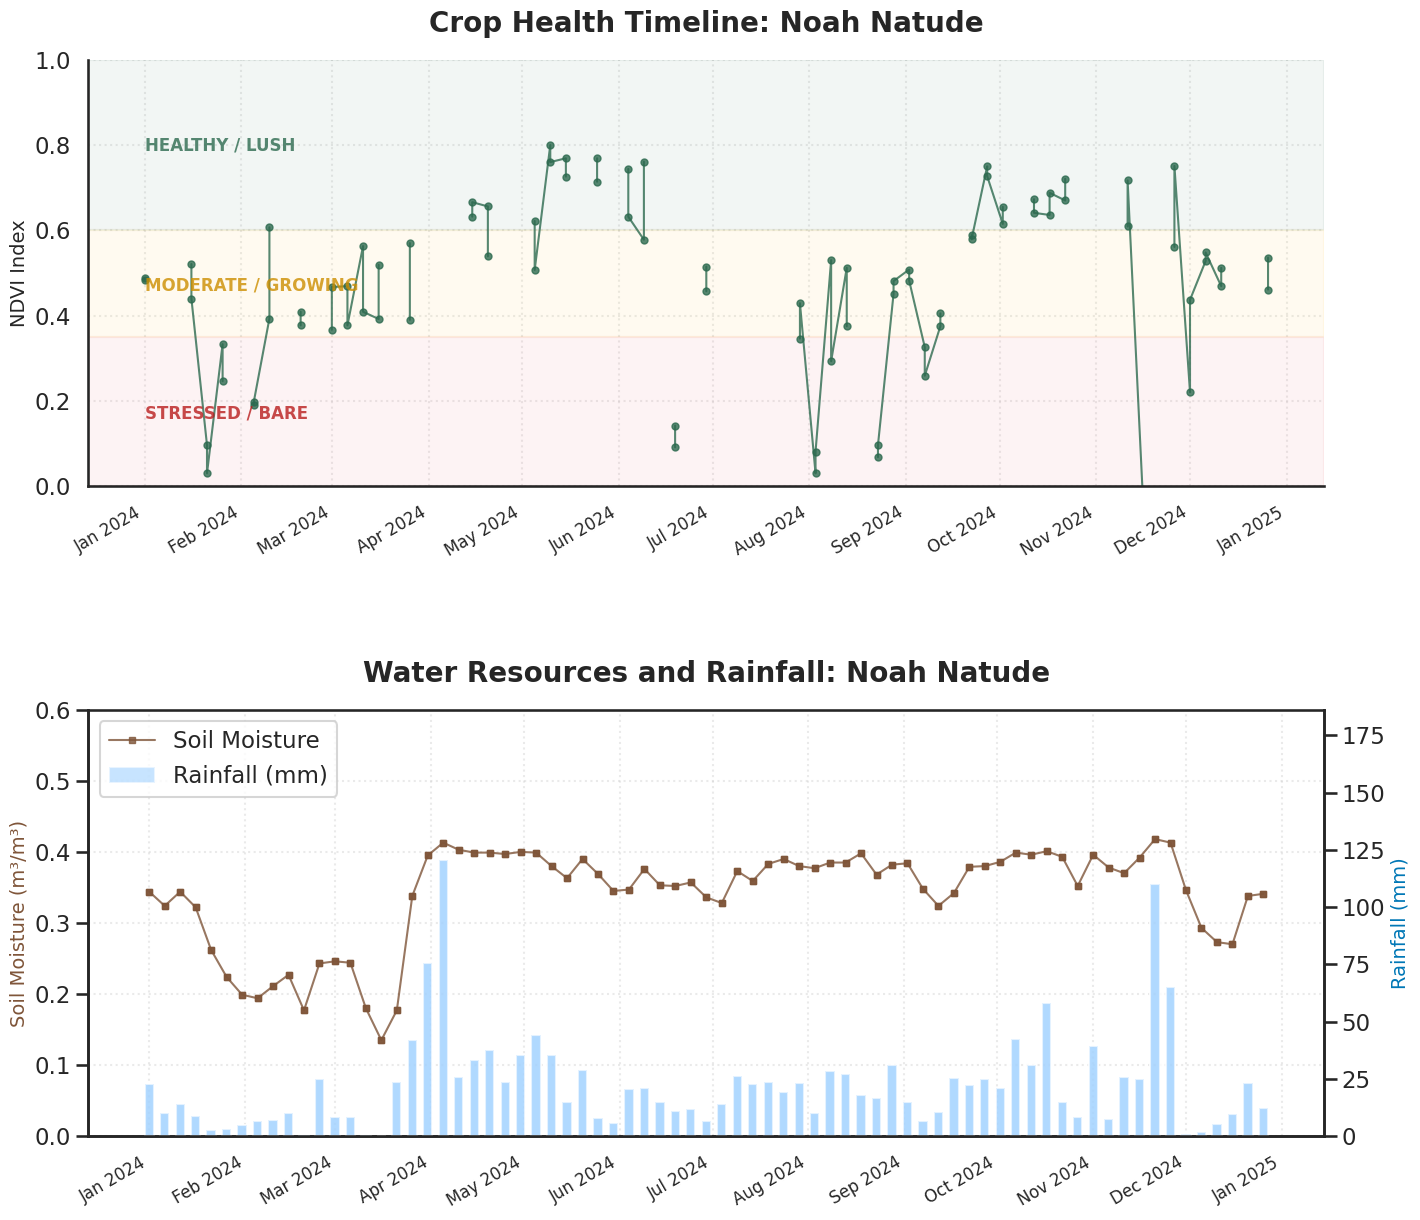



----------------------------------------------------------------------------------------------------
REPORT FOR: JAMES BALYA
CROPS: Oranges
----------------------------------------------------------------------------------------------------


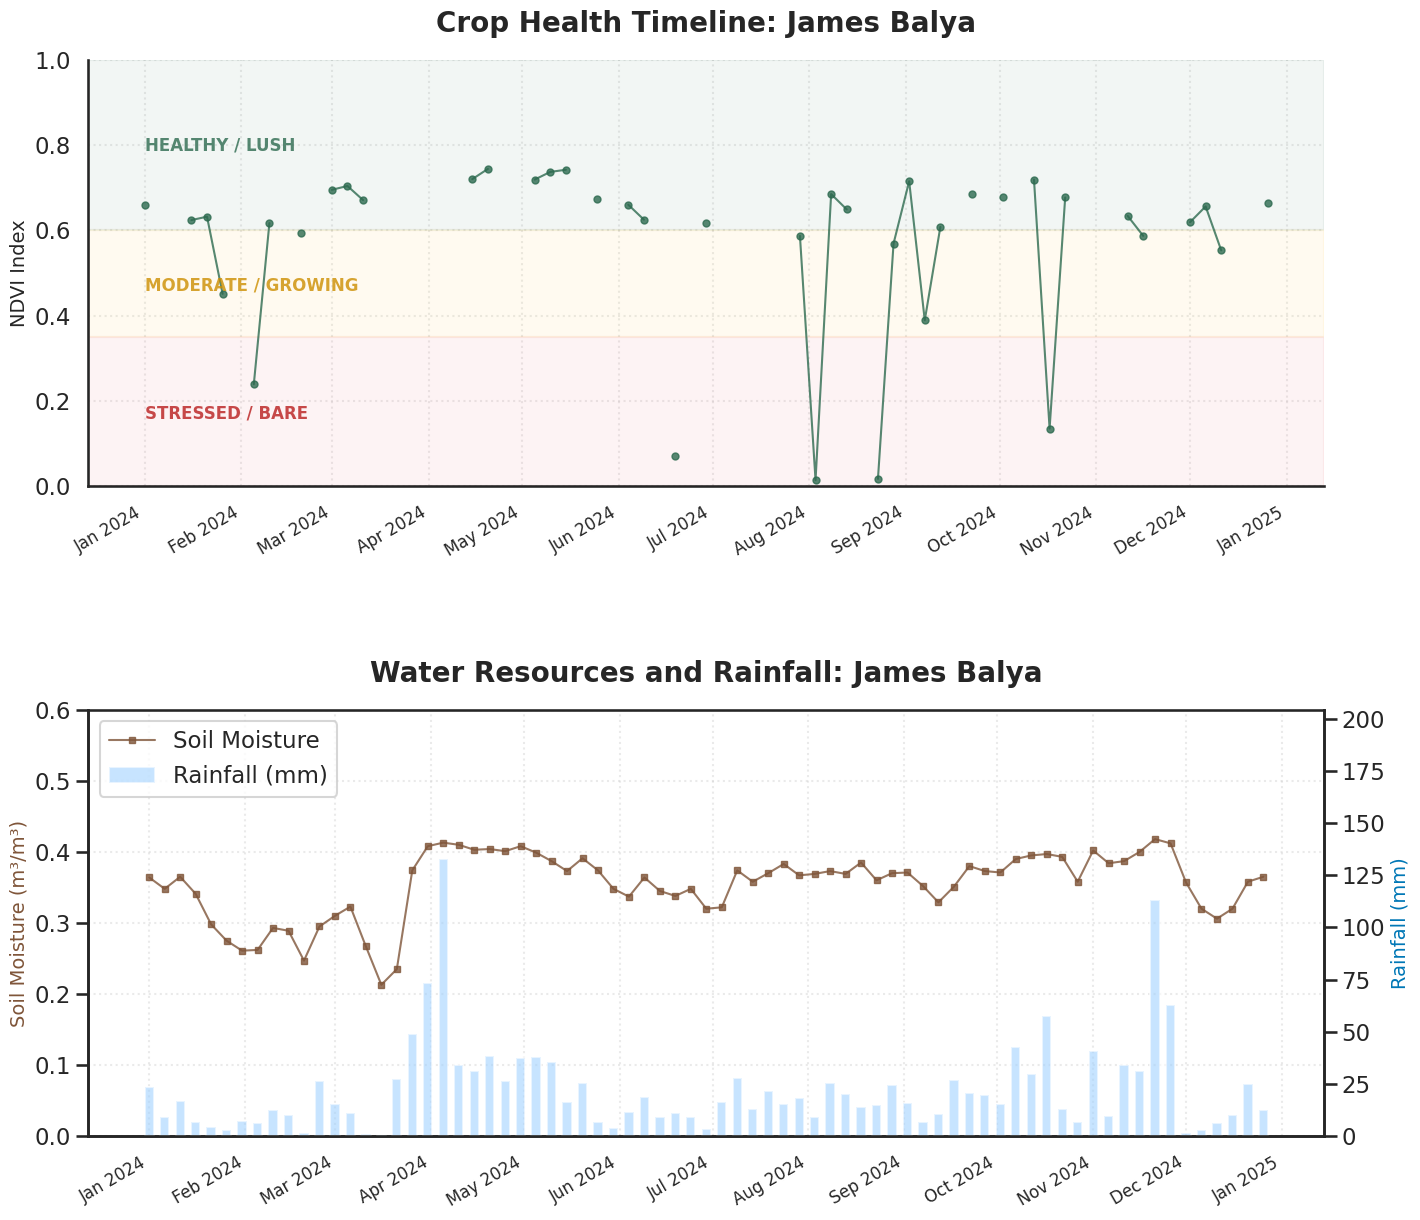



----------------------------------------------------------------------------------------------------
REPORT FOR: CORNELIUS KABERWA
CROPS: Rice
----------------------------------------------------------------------------------------------------


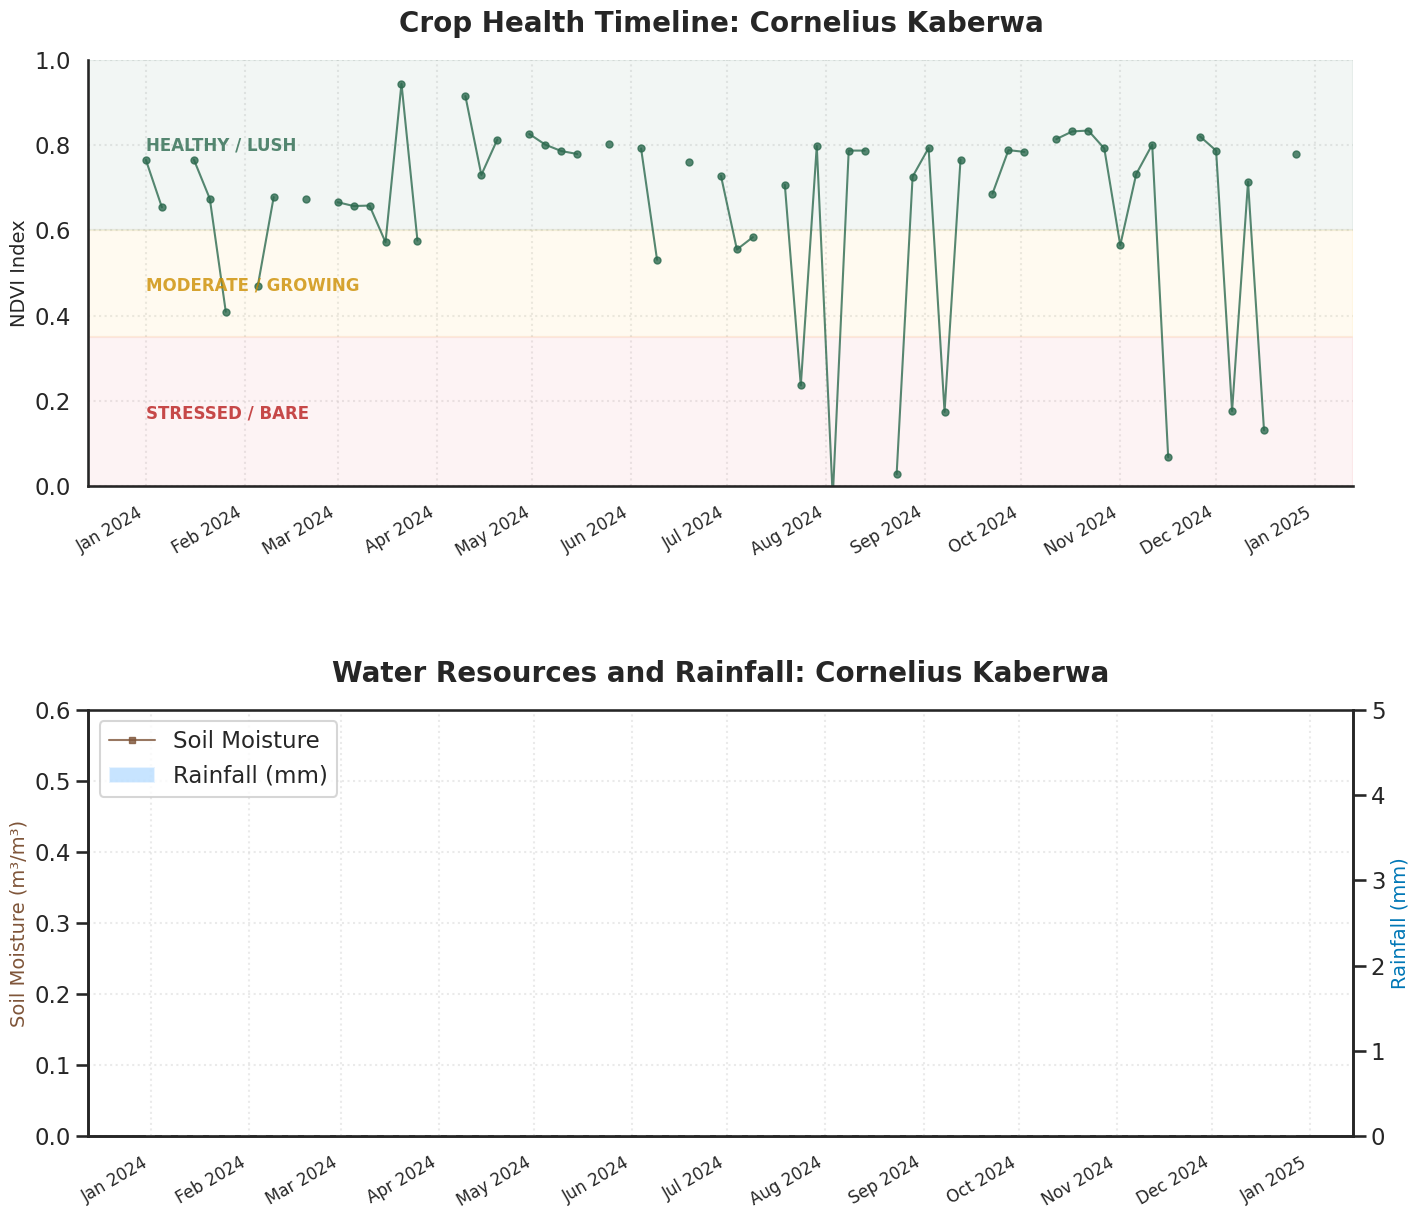

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

# Use a copy of the master database for plotting
plot_data = master_df.copy()
plot_data['Step_Start'] = pd.to_datetime(plot_data['Step_Start'])

def generate_clean_farmer_reports(df):
    """
    Generates personal dashboards with thin lines and small markers
    to improve clarity for high-frequency time-series data.
    """
    unique_farmers = df['Farmer_Name'].unique()

    # Set professional visual context
    sns.set_context("talk")
    sns.set_style("white")

    # Define the date format once for consistency
    date_form = mdates.DateFormatter('%b %Y')
    date_loc = mdates.MonthLocator(interval=1)

    for farmer in unique_farmers:
        farmer_data = df[df['Farmer_Name'] == farmer].sort_values('Step_Start')
        crops = farmer_data['Crops'].iloc[0]
        first_date = farmer_data['Step_Start'].min()

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))

        print("-" * 100)
        print(f"REPORT FOR: {farmer.upper()}")
        print(f"CROPS: {crops}")
        print("-" * 100)

        # --- SUBPLOT 1: CROP HEALTH (NDVI) ---
        # Line width reduced to 1.5 and marker size to 5 for better clarity
        ax1.plot(farmer_data['Step_Start'], farmer_data['NDVI'],
                 color='#2d6a4f', marker='o', linewidth=1.5, markersize=5,
                 label='NDVI (Crop Health)', alpha=0.8)

        # Shaded Background Zones
        ax1.axhspan(0.6, 1.0, color='#2d6a4f', alpha=0.06)   # Healthy (Green)
        ax1.axhspan(0.35, 0.6, color='#ffb703', alpha=0.06)  # Moderate (Yellow)
        ax1.axhspan(0, 0.35, color='#e63946', alpha=0.06)   # Stressed (Red)

        # Text Labels for Zones
        ax1.text(first_date, 0.8, 'HEALTHY / LUSH', color='#2d6a4f',
                 fontweight='bold', fontsize=12, va='center', alpha=0.8)
        ax1.text(first_date, 0.47, 'MODERATE / GROWING', color='#cc8e00',
                 fontweight='bold', fontsize=12, va='center', alpha=0.8)
        ax1.text(first_date, 0.17, 'STRESSED / BARE', color='#b91d1d',
                 fontweight='bold', fontsize=12, va='center', alpha=0.8)

        ax1.set_title(f"Crop Health Timeline: {farmer}", fontsize=20, pad=20, fontweight='bold')
        ax1.set_ylabel("NDVI Index", fontsize=14)
        ax1.set_ylim(0, 1)

        # Formatting for Top Axis
        ax1.xaxis.set_major_locator(date_loc)
        ax1.xaxis.set_major_formatter(date_form)
        plt.setp(ax1.get_xticklabels(), rotation=30, ha='right', fontsize=12)
        ax1.grid(True, linestyle=':', alpha=0.4)

        # --- SUBPLOT 2: WATER & SOIL (MOISTURE VS RAIN) ---
        # Soil Moisture Line (Reduced width and marker for consistency)
        ax2.plot(farmer_data['Step_Start'], farmer_data['Soil_Moisture_0_7cm'],
                 color='#7f5539', marker='s', linewidth=1.5, markersize=5,
                 label='Soil Moisture', alpha=0.8)
        ax2.set_ylabel("Soil Moisture (m³/m³)", color='#7f5539', fontsize=14)
        ax2.set_ylim(0, 0.6)

        # Rainfall Bars
        ax3 = ax2.twinx()
        ax3.bar(farmer_data['Step_Start'], farmer_data['Rainfall_mm'],
                color='#a2d2ff', alpha=0.6, width=3, label='Rainfall (mm)')
        ax3.set_ylabel("Rainfall (mm)", color='#0077b6', fontsize=14)

        # Scale Rainfall Y-axis
        max_rain = farmer_data['Rainfall_mm'].max()
        ax3.set_ylim(0, max_rain * 1.5 + 5)

        ax2.set_title(f"Water Resources and Rainfall: {farmer}", fontsize=20, pad=20, fontweight='bold')

        # Formatting for Bottom Axis
        ax2.xaxis.set_major_locator(date_loc)
        ax2.xaxis.set_major_formatter(date_form)
        plt.setp(ax2.get_xticklabels(), rotation=30, ha='right', fontsize=12)
        ax2.grid(True, linestyle=':', alpha=0.4)

        # Unified Legend for the bottom plot
        lines_1, labels_1 = ax2.get_legend_handles_labels()
        lines_2, labels_2 = ax3.get_legend_handles_labels()
        ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', frameon=True)

        # Clean borders
        sns.despine(ax=ax1, top=True, right=True)
        sns.despine(ax=ax2, top=True, right=False)

        plt.tight_layout(pad=4.0)
        plt.show()
        print("\n")

# Run the refined report generator
generate_clean_farmer_reports(plot_data)

In [29]:
from IPython.display import display, HTML

def generate_all_farmer_spatial_reports(target_date):
    print(f"STARTING BATCH SPATIAL SCOUTING: {target_date}")
    print("=" * 80)

    requested_date = ee.Date(target_date)
    start_window = requested_date.advance(-10, 'day')
    end_window = requested_date.advance(10, 'day')

    viz_health = {'min': 0.2, 'max': 0.8, 'palette': ['#d73027', '#f46d43', '#fee08b', '#d9ef8b', '#1a9850']}
    viz_moisture = {'min': -0.1, 'max': 0.5, 'palette': ['#f7fbff', '#9ecae1', '#2171b5', '#084594']}
    viz_soil = {'min': -18, 'max': -8, 'palette': ['#ffffd4', '#fed98e', '#fe9929', '#d95f0e', '#993404']}

    for farmer_name in farmer_portfolio.keys():
        display(HTML(f"<h2 style='color:#2d6a4f; border-bottom: 2px solid #2d6a4f; padding-bottom:10px;'>SPATIAL REPORT: {farmer_name.upper()}</h2>"))

        seen_coords = set()
        parcels = [f for f in farmer_portfolio[farmer_name] if not (tuple(tuple(c) for c in f['coords']) in seen_coords or seen_coords.add(tuple(tuple(c) for c in f['coords'])))]

        for idx, parcel in enumerate(parcels, 1):
            poly = get_farm_geometry(parcel['coords'])
            crops = parcel['crop']

            s2_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                      .filterBounds(poly)
                      .filterDate(start_window, end_window)
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 40))
                      .sort('CLOUDY_PIXEL_PERCENTAGE'))

            if s2_col.size().getInfo() == 0:
                print(f"Notice: No clear imagery for {farmer_name}'s {crops} plot.")
                continue

            img = s2_col.first()

            ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
            evi = img.expression('2.5 * ((B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1))',
                                 {'B8': img.select('B8'), 'B4': img.select('B4'), 'B2': img.select('B2')}).rename('EVI')
            ndre = img.normalizedDifference(['B8', 'B5']).rename('NDRE')
            ndmi = img.normalizedDifference(['B8', 'B11']).rename('NDMI')

            s1_col = (ee.ImageCollection('COPERNICUS/S1_GRD')
                      .filterBounds(poly)
                      .filterDate(start_window, end_window)
                      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')))

            # Create the Map
            m = geemap.Map() # Removed lite_mode
            m.centerObject(poly, 18)

            # Add Optical Layers
            m.addLayer(ndvi.clip(poly), viz_health, '1. NDVI (General Health)')
            m.addLayer(ndre.clip(poly), viz_health, '2. NDRE (Chlorophyll/Stress)')
            m.addLayer(evi.clip(poly), viz_health, '3. EVI (Biomass Intensity)')
            m.addLayer(ndmi.clip(poly), viz_moisture, '4. NDMI (Leaf Water/Drought)')

            # Add Radar Layer
            if s1_col.size().getInfo() > 0:
                sm_img = s1_col.median().select('VV').clip(poly)
                m.addLayer(sm_img, viz_soil, '5. Soil Moisture Proxy (Radar)')

            # Add Colorbars
            m.add_colorbar(viz_health, label="Health (Red=Low, Green=High)", orientation="horizontal")

            # IMPORTANT: This adds the layer selection menu to the map
            m.add_layer_control()

            print(f"Plot {idx}: {crops}")
            display(m)
            print("-" * 50)

# Run
generate_all_farmer_spatial_reports("2025-01-20")

STARTING BATCH SPATIAL SCOUTING: 2025-01-20


Plot 1: Maize


Map(center=[1.1167241242631634, 33.901863035764464], controls=(WidgetControl(options=['position', 'transparent…

--------------------------------------------------
Plot 2: Avocado


Map(center=[1.1170694468807458, 33.90130354040321], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------
Plot 3: Eucalyptus


Map(center=[1.1175296817891256, 33.90109001805665], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------


Plot 1: Coffee


Map(center=[1.0793370258808068, 33.88511660520535], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------
Plot 2: Cassava


Map(center=[1.0808868834993917, 33.88789114641576], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------
Plot 3: Maize


Map(center=[1.0797871745811696, 33.886541933317154], controls=(WidgetControl(options=['position', 'transparent…

--------------------------------------------------


Plot 1: Avocado


Map(center=[1.0563254390545402, 33.87740470938372], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------
Plot 2: Eucalyptus


Map(center=[1.0568556057807696, 33.87980807095329], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------
Plot 3: Maize


Map(center=[1.053410571475395, 33.88173170889449], controls=(WidgetControl(options=['position', 'transparent_b…

--------------------------------------------------


Plot 1: Tomatoes


Map(center=[1.0697739145988707, 33.88601309851582], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------
Plot 2: Rice


Map(center=[1.0673494746803012, 33.88623534364259], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------


Plot 1: Oranges


Map(center=[0.9826766513041757, 33.85844344052269], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------


Plot 1: Rice


Map(center=[1.1177027996598947, 33.90111663764568], controls=(WidgetControl(options=['position', 'transparent_…

--------------------------------------------------
